In [1]:
from strategy.competition import Competition
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
import numpy as np
import matplotlib.pyplot as plt

In [2]:
start_date = datetime(2016,1,1)
end_date = datetime(2021,1,1)
comp = Competition(start_date,end_date)

In [3]:
comp.subscribe()
# initial_data = comp.initial_transform()
# sim = comp.create_sim()

In [4]:
transforms = comp.rec_transform()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:11<00:00,  6.47s/it]


In [ ]:
models = comp.model()

competition_sim_ticker:  13%|████████▏                                                        | 64/505 [09:46<1:06:20,  9.03s/it]

BRK.B 'date'


competition_sim_ticker:  13%|████████▉                                                          | 67/505 [10:07<58:21,  7.99s/it]

TECH 'date'


competition_sim_ticker:  16%|██████████▋                                                        | 81/505 [11:57<38:20,  5.43s/it]

BRO 'date'
BF.B 'date'


competition_sim_ticker:  19%|█████████████                                                      | 98/505 [14:39<55:51,  8.23s/it]

CDAY 'date'


competition_sim_ticker:  26%|█████████████████▎                                                | 132/505 [19:45<48:20,  7.78s/it]

CTRA 'date'


competition_sim_ticker:  30%|███████████████████▉                                              | 153/505 [22:43<46:02,  7.85s/it]

In [ ]:
recs = comp.recommend()

In [6]:
len(sim[sim["date"]>=datetime(2017,12,1)]["ticker"].unique())

484

In [28]:
start_year = comp.start_date.year
end_year = comp.end_date.year
categories_nums = comp.modeling_params["categories"]
model_training_year = comp.modeling_params["model_training_year"]
sims = []
market = comp.subscriptions["market"]["db"]
market.connect()
sp5 = market.retrieve("sp500")
comp.db.connect()
for year in tqdm(range(2017,2017+1),desc="competition_sim_year"):
    for quarter in tqdm(range(1,2),desc="competition_sim_quarter"):
        for ticker in tqdm(list(sp5["Symbol"].unique()[2:3]),desc="competition_sim_ticker"):
            try:
                model_data = comp.db.retrieve_transformed(ticker)
                model_data.sort_values("date",ascending=True,inplace=True)
                model_data.reset_index(inplace=True,drop=True)
                first_index = model_data[(model_data["year"] == (year - model_training_year)) & (model_data["quarter"]==quarter)].index.values.tolist()[0]
                last_index = model_data[(model_data["year"] == year) & (model_data["quarter"]==quarter)].index.values.tolist()[0]
                training_data = model_data.iloc[first_index:last_index].reset_index(drop=True)
                prediction_data = model_data[(model_data["year"] == year) & (model_data["quarter"]==quarter)].reset_index()
                print(year,quarter,ticker,first_index,last_index,model_data.index.size,training_data.index.size,prediction_data.index.size)
                factor_cols = [x for x in training_data.columns if x not in ["year","quarter","week","y","ticker","date"]]
                factors = []
                for factor in factor_cols:
                    if len([x for x in training_data[factor].isna() if x]) / training_data.index.size > 0.8:
                        factors.append(factor)
                X = training_data[factors].fillna(method="ffill").fillna(method="bfill")
                y = training_data["y"].fillna(method="ffill").fillna(method="bfill")
                models = m.regression({"X":X,"y":y})
#                 models["year"] = year
#                 models["quarter"] = quarter
                sim = prediction_data.fillna(method="ffill").fillna(method="bfill")
#                 X = training_data[factor_cols]
#                 y = training_data["y"]
#                 models = m.regression({"X":X,"y":y})
#                 models["year"] = year
#                 models["quarter"] = quarter
#                 sim = prediction_data
#                 for i in range(models.index.size):
#                     model = models.iloc[i]
#                     api = model["api"]
#                     score = model["score"]
#                     if score >= comp.modeling_params["score_requirement"]/100:
#                         sim[f"{api}_prediction"] = model["model"].predict(sim[factor_cols])
#                         sim[f"{api}_score"] = model["score"].item()
#                 ticker_data = market.retrieve_ticker_prices("prices",ticker)
#                 prices = p.column_date_processing(ticker_data)
#                 prices["year"] = [x.year for x in prices["date"]]
#                 prices["week"] = [x.week for x in prices["date"]]
#                 sim = p.column_date_processing(sim)
#                 sim["year"] = [x.year for x in sim["date"]]
#                 sim["week"] = [x.week for x in sim["date"]]
#                 sim = prices[["date","year","week","ticker","adjclose"]].merge(sim.drop("date",axis=1),on=["year","week","ticker"],how="right").dropna()
#                 sim["categories"] = categories_nums
#                 final_cols = ["date","ticker","adjclose","categories"]
#                 final_cols.extend([x for x in list(sim.columns) if "prediction" in x or "score" in x])
#                 sim = sim[final_cols]
#                 sim.fillna(0,inplace=True)
#                 sim["prediction"] = [np.nanmean([row[1][x] for x in sim.columns if "prediction" in x and row[1][x] != 0]) for row in sim.iterrows()]
#                 sim["score"] = [np.nanmean([row[1][x] for x in sim.columns if "score" in x and row[1][x] != 0]) for row in sim.iterrows()]
#                 sim["delta"] = (sim["prediction"] - sim["adjclose"]) / sim["adjclose"]
#                 for param in comp.modeling_params:
#                     sim[param]=comp.modeling_params[param]
#                 if sim.index.size > 1:
#                     comp.db.store("sim",sim)
#                     sims.append(sim)
            except Exception as e:
                print(ticker,str(e))
comp.db.disconnect()
market.disconnect()

competition_sim_quarter:   0%|                                                                                                                      | 0/1 [00:00<?, ?it/s]

competition_sim_ticker:   0%|                                                                                                                       | 0/1 [00:00<?, ?it/s]

2017 1 ABBV 548 877 2484 329 78




competition_sim_ticker: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.45s/it]

competition_sim_year: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.46s/it]


In [13]:
model_data.iloc[first_index:last_index]

,year,quarter,week,y,ACN,ADBE,AMD,AKAM,APH,ADI,...,PGR,PLD,RJF,SO,SIVB,TGT,TMO,UAL,VLO,XEL
548,2016,1,1,90.989099,91.545229,90.458,2.4880,50.22,23.069170,46.077607,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
549,2016,1,1,90.989099,91.545229,90.458,2.4880,50.22,23.069170,46.077607,...,25.401127,35.687009,33.026607,36.234862,112.664,62.14126,134.321602,54.078,54.634319,30.510069
550,2015,4,53,91.545229,95.359992,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
551,2016,1,1,90.989099,91.545229,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
552,2015,4,53,91.545229,95.359992,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,2016,4,52,107.634759,108.517638,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873,2016,4,52,107.634759,108.517638,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
874,2016,4,52,107.634759,108.517638,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
875,2016,4,52,107.634759,108.517638,103.845,11.6375,67.27,32.263982,66.806375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
models

,api,model,score,model_type,year,quarter
0,skl,LinearRegression(),0.015167,regression,2016,1
1,xgb,"XGBRegressor(base_score=0.5, booster='dart', c...",-49.957633,regression,2016,1
2,light,"LGBMRegressor(boosting_type='dart', early_stop...",-64.282746,regression,2016,1
3,cat,<catboost.core.CatBoostRegressor object at 0x0...,-50.082306,regression,2016,1


In [23]:
analysis = sim

In [24]:
analysis.head(2)

,date,ticker,adjclose,categories,prediction,score,delta,model_training_year,score_requirement
0,2016-01-04,CRM,76.71,2,NaN,NaN,NaN,1,70
1,2016-01-05,CRM,77.05,2,NaN,NaN,NaN,1,70


In [25]:
analysis["year"] = [x.year for x in analysis["date"]]
analysis["week"] = [x.quarter for x in analysis["date"]]
# analysis["date"] = [datetime.strptime(f'{row[1]["year"]} {row[1]["week"]} 0', "%Y %W %w") for row in analysis.iterrows()]

In [28]:
analysis.dropna()

,date,ticker,adjclose,categories,prediction,score,delta,model_training_year,score_requirement,year,week


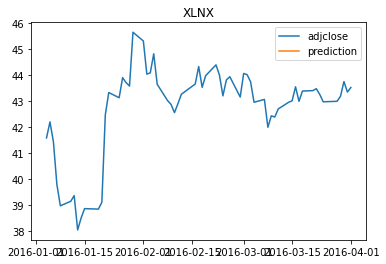

In [27]:
ticker_example = analysis[analysis["ticker"]==ticker].sort_values("date")
plt.plot(ticker_example["date"],ticker_example["adjclose"])
for col in [x for x in analysis.columns if "prediction" in x]:
    plt.plot(ticker_example["date"],ticker_example[col])
legend = ["adjclose"]
legend.extend([x for x in analysis.columns if "prediction" in x])
plt.legend(legend)
plt.title(ticker)
plt.show()